# Exploring cellular automata for track finding in simulated Geant4 data
### Andrei R. Hanu - andrei.hanu@nasa.gov

The cellular automaton method was first applied for pattern recognition in particle detectors in 1992 and has evolved since then. The algorithm I used in this example is based on the most recent described in the literature with modifications that account for the fact that AdEPT has no “a priori” knowledge of the interaction point, or incident particle direction, since detector has approximately 4$\pi$ sensitivity.

References:

+ Back, J. J., et al. "Implementation of a cellular automaton algorithm for neutrino interaction reconstruction in a liquid argon volume." The European Physical Journal C 73.10 (2013): 1-8.

+ Frühwirth, Rudolf, et al. "Track finding in silicon trackers with a small number of layers." Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment 732 (2013): 95-98.

+ Glattauer, Robin, et al. "Forward Tracking in the ILD Detector." arXiv preprint arXiv:1202.2761 (2012).

In a traditional cellular automaton, the cell is usually represented by a pixel in an image that describes a cell as either dead or alive. For particle tracking applications, this definion of a cell cannot be used since we know with hit certainty the location of where that particle deposited it's energy. Instead, we are trying to determine the most likely path that the particle took by "stringing together" a collection of hits. As such, the definition of a cell is changed from its original pixel type nature to that of a connection between two detector hits which we call a track segment.

The algorithm consists of three steps: (1) state initialization, (2) finite state evolution, and (3) post-processing.


In [31]:
# Matplotlib & other data plotting libraries
from matplotlib import pyplot as plt
from matplotlib import ticker as plticker
from matplotlib import collections as mc
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import seaborn
from brewer2mpl import brewer2mpl

# Python Iteration
import itertools

# Numpy 
import numpy as np

# OpenCV
import cv2

# Python timing module
import timeit

# Show matplotlib figures inline the notebook
%matplotlib inline

In [32]:
##########################################################################################
# rcParams (Publication Quality Graphs)

fig_width_pt = 246.0  					# Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0 		# Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# Width in inches
fig_height = fig_width*golden_mean 		# Height in inches
#fig_size =  [fig_width, fig_height]
fig_size =  [7.3,4.2]
params = {'backend': 'pdf',
		'axes.labelsize': 16,
		'legend.fontsize':16,
		'xtick.labelsize': 16,
		'ytick.labelsize': 16,
		'font.family': 'sans-serif',
		'font.sans-serif': 'Avant Garde',
		'font.size': 16,
		'text.usetex': True,
		'figure.figsize': fig_size}

rcParams.update(params)

# Load the simulation images from Geant4

Description of the images.

In [33]:
# Load the Geant4 simulation images
imgXZ = cv2.imread('Data/electrons/e-_5MeV_XZ_event_0.png',cv2.IMREAD_GRAYSCALE)
imgYZ = cv2.imread('Data/electrons/e-_5MeV_YZ_event_0.png',cv2.IMREAD_GRAYSCALE)

# Get the dimensions of the two images
rowsXZ,colsXZ = imgXZ.shape
rowsYZ,colsYZ = imgYZ.shape

# Crop the images
# imgXZ = imgXZ[1520:1820,2050:2350]
# imgYZ = imgYZ[1520:1820,2050:2350]

# Find all the hits (pixel value > 0)
imgXZHits = np.column_stack(np.where(imgXZ>0))
imgYZHits = np.column_stack(np.where(imgYZ>0))

# Sort all the hits
# First by column 1 in ascending order 
# Then by column 0 in ascending order
imgXZHits = imgXZHits[np.lexsort((imgXZHits[:, 0],imgXZHits[:, 1]))]
imgYZHits = imgYZHits[np.lexsort((imgYZHits[:, 0],imgYZHits[:, 1]))]

# Size of images (Bytes)
# print 'Size of imgXZ in memory:', imgXZ.nbytes/1E6, 'MB'
# print 'Size of imgYZ in memory:', imgYZ.nbytes/1E6, 'MB'
# print 'Size of imgXZHits in memory:', imgXZHits.nbytes/1E6, 'MB'
# print 'Size of imgYZHits in memory:', imgYZHits.nbytes/1E6, 'MB'

Saving raw image of detector hits to: Detector_Raw_Data_XZ.pdf


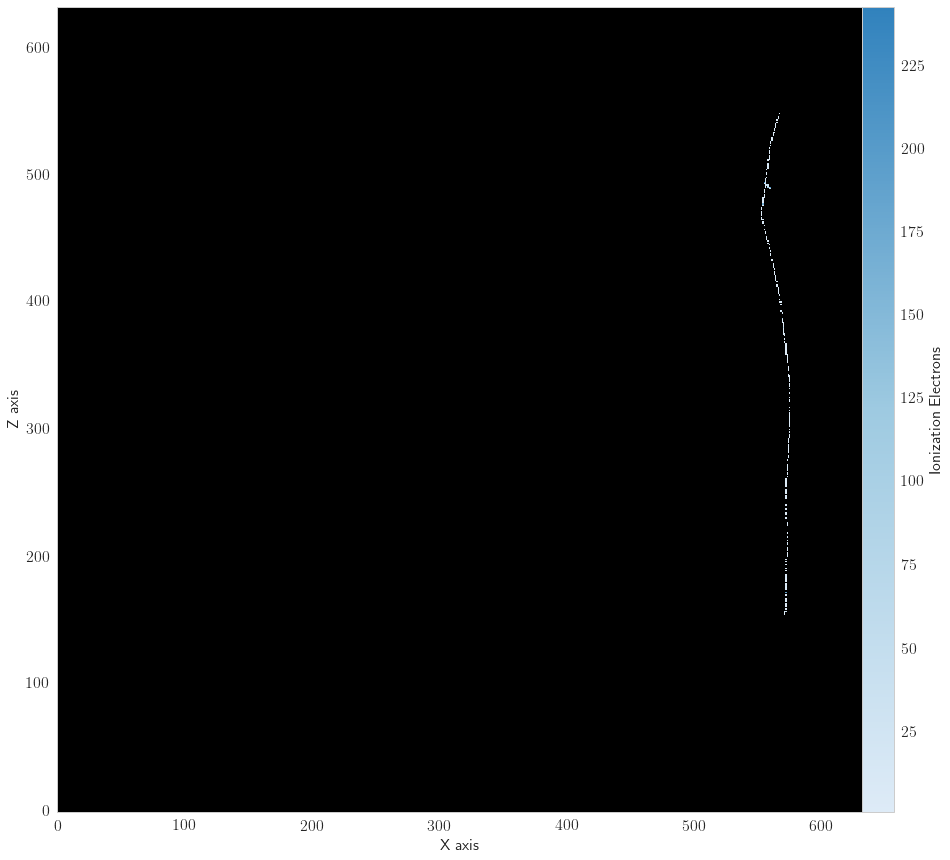

In [34]:
##### Plot the detector raw data
figRawXZ = plt.figure(figsize=(15, 15))
axRawXZ = ImageGrid(figRawXZ, 111, # similar to subplot(111)
                nrows_ncols = (1, 1), # creates 2x2 grid of axes
                axes_pad=0., # pad between axes in inch.
                cbar_location="right",
                cbar_mode="single",
                cbar_size="4%",
                cbar_pad=-0.01,
                )

# Color map
cmap = brewer2mpl.get_map('Blues', 'sequential', 3, reverse=False).mpl_colormap
cmap.set_under('black')

# Load the detector hits into matplotlib
H1 = axRawXZ[0].imshow(np.transpose(imgXZ), cmap = cmap, origin='lower',
               norm = Normalize(vmin=np.min(imgXZ)+1,vmax=np.max(imgXZ), clip=False), interpolation='nearest')

# With cbar_mode="single", cax attribute of all axes are identical.
cbar = plt.colorbar(H1, cax = axRawXZ.cbar_axes[0])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Ionization Electrons')

for cax in axRawXZ.cbar_axes:
    cax.toggle_label(True)

# Axis Range
# axRawXZ[0].set_xlim(0,210)
# axRawXZ[0].set_ylim(0,210)
# axRawXZ[0].set_xlim(100,200)
# axRawXZ[0].set_ylim(100,150)

# Axis Labels
axRawXZ[0].set_xlabel('X axis')
axRawXZ[0].set_ylabel('Z axis')

# xTicks = np.array([50,100,150,200])
# yTicks = np.array([50,100,150,200])

# axRawXZ[0].set_xticks(xTicks) 
# axRawXZ[0].set_yticks(yTicks) 

# Turns off grid on the left Axis.
seaborn.set_style("whitegrid", {'axes.grid' : False})

# Save the figure 
fileRawXZ ='Detector_Raw_Data_XZ.pdf'
plt.savefig(fileRawXZ)
print 'Saving raw image of detector hits to: ' + fileRawXZ

# Show the image
plt.show(figRawXZ)

Saving raw image of detector hits to: Detector_Hits_XZ.pdf


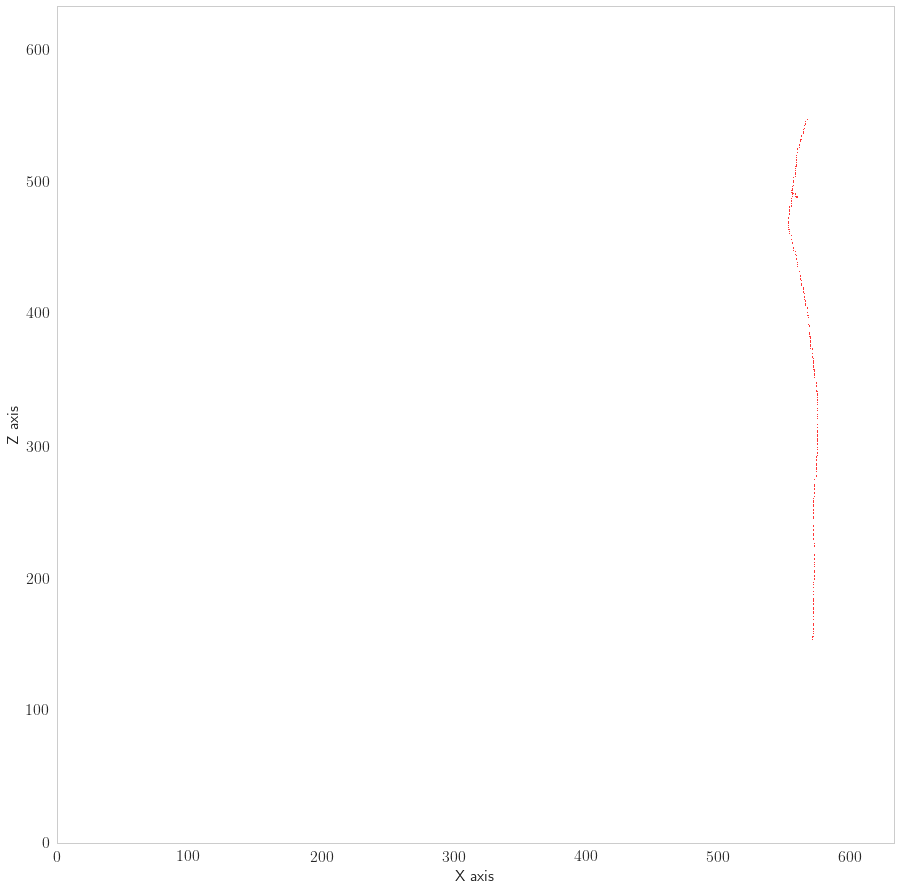

In [35]:
##### Plot the detector hits
figHitsXZ = plt.figure(figsize=(15, 15))
axHitsXZ = ImageGrid(figHitsXZ, 111, # similar to subplot(111)
                nrows_ncols = (1, 1), # creates 2x2 grid of axes
                axes_pad=0.
                )

# Load the detector hits into matplotlib
axHitsXZ[0].plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=2, color='red') 

# Axis Range
# axHitsXZ[0].set_xlim(0,211)
# axHitsXZ[0].set_ylim(0,211)
axHitsXZ[0].set_xlim(0,rowsXZ)
axHitsXZ[0].set_ylim(0,colsXZ)

# Axis Labels
axHitsXZ[0].set_xlabel('X axis')
axHitsXZ[0].set_ylabel('Z axis')

# xTicks = np.array([50,100,150,200])
# yTicks = np.array([50,100,150,200])

# axHitsXZ[0].set_xticks(xTicks) 
# axHitsXZ[0].set_yticks(yTicks) 

# Save the figure 
fileHitsXZ ='Detector_Hits_XZ.pdf'
plt.savefig(fileHitsXZ)
print 'Saving raw image of detector hits to: ' + fileHitsXZ

# Show the image
plt.show(figHitsXZ)

In [36]:
# ##### Plot the detector hits in both projections
# figHits, (axHitsXZ, axHitsYZ) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))

# # Load the detector hits into matplotlib
# axHitsXZ.plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=3, color='red') 
# #axHitsXZ.scatter(imgXZHits[:,0], imgXZHits[:,1], color='red', marker='o', s=0.5)
# axHitsYZ.plot(imgYZHits[:,0], imgYZHits[:,1], '.', ms=3, color='red') 
# #axHitsYZ.scatter(imgYZHits[:,0], imgYZHits[:,1], color='red', marker='o', s=0.5)

# # Axis Range
# axHitsXZ.set_xlim(0,211)
# axHitsXZ.set_ylim(0,211)
# axHitsYZ.set_xlim(0,211)
# axHitsYZ.set_ylim(0,211)

# # Axis Labels
# axHitsXZ.set_xlabel('X axis')
# axHitsXZ.set_ylabel('Z axis')
# axHitsYZ.set_xlabel('Y axis')

# # Figure Properties
# axHitsXZ.set_title('Detector hits in XZ projection')
# axHitsYZ.set_title('Detector hits in YZ projection')
# figHits.subplots_adjust(wspace=0.08)

# # Save the figure 
# fileHits ='Detector_Hits.pdf'
# plt.savefig(fileHits)
# print 'Saving plot of detector hits to: ' + fileHits

# # Show the image
# plt.show(figHits)

# Track segment initialization

The track segment initialization is a process which generates a plausible set of track segments between pairs of detector hits. A track segment is defined as the straight line connecting a "forward" and "backward" pair of hits. The terms forward and backward describe the relative position of a hit in relation to another hit and the principal detector axis. For AdEPT, I have arbitrarily chosen the Z-axis as the principal detector axis. As such, detector hits which have Z coordinates larger than the Z of the search positions are considered "forward" of the current search hit. Similarly if the their Z coordinate is smaller, they are considered "backward" of the current search hit.

In principle, every detector hit can be connected to another to form a track segment. However, this is approach is combinatorially expensive and not an accurate representation of the physics describing the traversal of a charged particle through the detector. Instead, it is better to limit the track segment initialization to detector hits which are classified as neighbours and within a small radius of each other. 

The algorithm I used to implement the track segment initialization for AdEPT is described below:

First:

+ Implement a kd-tree or quadtree of detector hits that can be used for a nearest neighbour search

For each detector hit:

1. Perform a nearest neighbour search to build a list of neighbours within a small search radius (rSearch) of each hit
+ Filter the neighbour list and select only those neighbours which are forward of the current hit with respect to the principal axis
+ Generate a track segment for each remaining forward neighbour, pointing from that hit to the current central hit
+ If no forward track segments are created, expand the search radius by a fixed step (rStep) and repeat the above procedure until either a track segment is generated or the maximum search radius (rMax) is reached.
+ If multiple forward track segments are created, filter out longer copies of track segments with the same slope. This step avoids making long track segments which "jump" over several hits.

# Build a kd-tree of detector hits

One of the fastest methods to perform a nearest neighbour search on a highly structured and heterogenous data sets, such as the AdEPT track structures, is by storring the detector hits into some sort of a tree structure. Some useful tree structures which could be considered for this application are the quadtree and kd-tree. For the pure hardware implementation, a quadtree would probably be a better approach, however, Python has some efficient and well tested kd-tree implementations and I have opted to used these instead of writing and optimizing my own quadtree implementation.

The SciPy module has two well tested kd-tree implementations: KDTree and cKDTree. The fundamental difference between the two is that cKDTree has been optimized using C function calls and in some cases it's been shown to be faster than the pure Python implementation. However, for highly structured data such as the one expected from tracks in the AdEPT instrument, the Python implementation has demonstrated better benchmarking results. See link: https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/


In [37]:
from scipy.spatial import KDTree, cKDTree

# Insert XZ hits into a kd-tree
# %timeit treeXZ = cKDTree(imgXZHits,leafsize=15)
treeXZ = cKDTree(imgXZHits,leafsize=15)

# Initial track segment generation

In [38]:
# Function to calculate the angle between a track segment and the Z-axis
# Return angle and magnitude
#
# Expects a numpy ndarrays [x_i z_i x_f z_f] where:
# x_i - starting x coordinate
# z_i - starting z coordinate
# x_f - final x coordinate
# z_f - final z coordinate

def calcSegmentAngleLength(segA):
    # Create vectors
    vA = [(segA[2]-segA[0]),(segA[3]-segA[1])]
    vZ = [(0),(1)]
    vX = [(1),(0)]
    
    # Calculate the dot product between the input vector and Z/X axis
    dotvAZ = np.dot(vA,vZ)
    dotvAX = np.dot(vA,vX)
    
    # Calculate the magnitude of the input vector
    magA = np.dot(vA, vA)**0.5
    
    # Return the angle in degrees
    if dotvAX >= 0:
        return np.degrees(np.arccos(dotvAZ/magA)),magA
    else:
        return -1*np.degrees(np.arccos(dotvAZ/magA)),magA

In [39]:
# The minimum and maximum search radii
rMin = 5
rMax = 45
rStep = 1

# Acceptance angle for overlaping tracks (+/- degrees)
thetaAcpt = 15

# Initialize a list which stores the track segments
# trackSeg[0:1] = X,Z pair for Hit 1
# trackSeg[2:3] = X,Z pair for Hit 2
trackSeg = []

# Loop through all of the hits and find their nearest neighbours starting from the smallest radius to the largest
# The principal axis is Z

# Move in the forward direction
for (x,z) in imgXZHits:
    # Start with the smallest search radius
    rSearch = rMin
    
    # Initialize a list of potential track segments from the current hit
    potTrackSeg = []
    
    # Find all of the nearest neighbours of the current 
    # Search until you find something or the search radius exceeds the maximum allowed limit
    while rSearch < rMax:
        # Find all neighbouring hits within distance r of the current hit
        hitsNear = imgXZHits[treeXZ.query_ball_point([x, z], rSearch)]
        
        # Filter hits in the forward direction
        hitsForward = hitsNear[hitsNear[:,1] >= z]
        
        # Are there any hits forward of the current search hit?
        if len(hitsForward) > 0: 
            # Loop through the potential list of forward neighbours
            for (xNN,zNN) in hitsForward:
                # Skip the current search hit since it will also be found in the tree
                if (xNN,zNN) != (x,z):
                    # We need to be careful for hits on the same Z axis such that the potential track segments
                    # are connected from lowest X coordinate to the highest 
                    # This will help to filter out overlaping track segments
                    if (zNN == z) and (xNN > x):
                        # Same Z
                        # Connect low X to high X
                        potTrackSeg.append(np.array([x,z,xNN,zNN]))
                    elif (zNN > z):
                        potTrackSeg.append(np.array([x,z,xNN,zNN]))
            
            # Did we make any potential track segments
            if len(potTrackSeg) > 0:
                # Yes, but they need to be filtered for duplicate angles
                # If multiple tracks have approximately the same angle, keep the shortest one
                for i in range(len(potTrackSeg)):
                    # Assume the track segment is a good candidate until otherwise
                    goodSegment = True
                    for j in range(len(potTrackSeg)):
                        if i != j:
                            # Compare angles & lengths
                            segi,leni = calcSegmentAngleLength(potTrackSeg[i])
                            segj,lenj = calcSegmentAngleLength(potTrackSeg[j])
                            if np.absolute(segi-segj) < thetaAcpt:
                                # These segments are too close in angle
                                if leni > lenj:
                                    # The current search segment is not the shortest and therefore not a valid segment
                                    goodSegment = False
                                    break
                                    
                    # If this segment is still good, append to list
                    if goodSegment == True:
                        trackSeg.append(potTrackSeg[i])
                
                # We've made a good track segment. Let's stop the search here!
                rSearch = rMax 
            else:
                # Not yet! Increase the search radius
                rSearch += rStep
        else:
            # Not yet! Increase the search radius
            rSearch += rStep

# Stack the list vertically into a numpy array
trackSeg = np.vstack(trackSeg)

# Filter for unique track segments
trackSeg= np.vstack({tuple(row) for row in trackSeg})

# Sort the track segments
# First by column 1 in ascending order 
# Then by column 0 in ascending order
# Then by column 3 in ascending order
# Then by column 2 in ascending order
trackSeg = trackSeg[np.lexsort((trackSeg[:, 2],trackSeg[:, 3],trackSeg[:, 0],trackSeg[:, 1]))]

# Output some useful information
print 'Initial track segments:', len(trackSeg)

Initial track segments: 431


# Plot the initial track segments

Saving plot of initial track segments for the XZ projection to: Track_Segments_Initial_CA_XZ.pdf


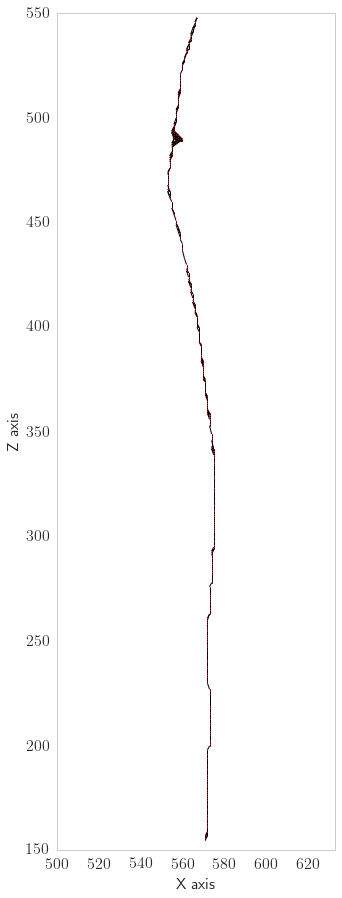

In [40]:
##### Plot initial track segments for XZ projection
figTrackSegXZ = plt.figure(figsize=(15, 15))
axTrackSegXZ = ImageGrid(figTrackSegXZ, 111, # similar to subplot(111)
                nrows_ncols = (1, 1), # creates 2x2 grid of axes
                axes_pad=0.
                )

# Use LineCollection to efficiently plot the many track segments
lc = mc.LineCollection(zip(zip(trackSeg[:,0],trackSeg[:,1]),zip(trackSeg[:,2],trackSeg[:,3])), linewidths=1,color='k')
lc2 = mc.LineCollection(zip(zip(trackSeg[:,0],trackSeg[:,1]),zip(trackSeg[:,2],trackSeg[:,3])), linewidths=1,color='k')
H1 = axTrackSegXZ[0].add_collection(lc)

# Load the image data from CV2 into matplotlib
axTrackSegXZ[0].plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=2, color='red') 

# Axis Properties
axTrackSegXZ[0].set_xlim(500,rowsXZ)
axTrackSegXZ[0].set_ylim(150,550)
# axTrackSegXZ[0].set_xlim(100,200)
# axTrackSegXZ[0].set_ylim(100,150)

axTrackSegXZ[0].set_xlabel('X axis')
axTrackSegXZ[0].set_ylabel('Z axis')

# xTicks = np.array([50,100,150,200])
# yTicks = np.array([50,100,150,200])

# axTrackSegXZ[0].set_xticks(xTicks) 
# axTrackSegXZ[0].set_yticks(yTicks) 

# Figure Properties
# axTrackHitsXZ.set_title('Detector hits in XZ projection')
# axTrackSegXZ.set_title('Initial Track Segments in XZ Projection')
# figTrackSegXZ.subplots_adjust(wspace=0.08)

# # Inset magnified plot
# axIns = zoomed_inset_axes(axTrackSegXZ[0],1.75,loc=4) # zoom=6
# axIns.plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=10, color='red') 
# axIns.add_collection(lc2)

# # sub region of the original image
# # x1, x2, y1, y2 = 20, 50, 50, 80
# x1, x2, y1, y2 = 5, 35, 100, 150
# axIns.set_xlim(x1, x2)
# axIns.set_ylim(y1, y2)
# plt.xticks(visible=False)
# plt.yticks(visible=False)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(axTrackSegXZ[0], axIns, loc1=1, loc2=3, fc="0.95", ec="0.05")

# Save the figure 
fileTrackSegXZ ='Track_Segments_Initial_CA_XZ.pdf'
plt.savefig(fileTrackSegXZ)
print 'Saving plot of initial track segments for the XZ projection to: ' + fileTrackSegXZ

# Show the image
plt.show(figTrackSegXZ)

# Calculating the angle between neighbouring track segments

The angle between neighbouring track segments is calculated using the dot product method as follows:

1. Create two vectors for each track segment


In [41]:
# Function to calculate the angle between two neighbouring track segments
#
# Expects two numpy ndarrays [x_i z_i x_f z_f] where:
# x_i - starting x coordinate
# z_i - starting z coordinate
# x_f - final x coordinate
# z_f - final z coordinate

def calcTrackSegmentAngle(segA, segB):
    # Create vectors
    vA = [(segA[2]-segA[0]),(segA[3]-segA[1])]
    vB = [(segB[2]-segB[0]),(segB[3]-segB[1])]
    
    # Calculate the dot product between the vectorss
    dotvAvB = np.dot(vA,vB)
    
    # Calculate the magnitude of each vector
    magA = np.dot(vA, vA)**0.5
    magB = np.dot(vB, vB)**0.5
    
    # Return the angle in degrees
    return np.degrees(np.arccos(dotvAvB/magA/magB))

# Cellular Automaton Forward



In [42]:
# Threshold angle between neighbouring track segments that share a common middle point
# In degrees
thetaMax = 45

# Number of track segments
numTrackSeg = trackSeg.shape[0]

# State of each track segment
stateCurrent = np.zeros(numTrackSeg, dtype=np.int64)

# Run the cellular automaton
while True:
    # Initialize the update state array
    stateUpdate = np.zeros(numTrackSeg, dtype=np.int64)

    # Loop through all the track segments
    for i in range(0,numTrackSeg):
        for j in range(i+1,numTrackSeg):
            # Find neighbouring track segments in the forward direction and with the same state
            if np.equal(trackSeg[i,2:4],trackSeg[j,0:2]).all() and (stateCurrent[i] == stateCurrent[j]):
                # Is the angle between track segments below our threshold angle?
                segAngle = calcTrackSegmentAngle(trackSeg[i],trackSeg[j])
                if  segAngle < thetaMax:
                    # The angle between neighbouring track segments is within the threshold angle
                    # Update the state for this neighbours
                    stateUpdate[j] = 1
    
    if np.sum(stateUpdate) > 0:
        # Update the status of all the track segments
        stateCurrent += stateUpdate
    else:
        break

# Plot the track segments after the forward Cellular Automaton

Saving plot of initial track segments for the XZ projection to: Track_Segments_Forward_CA_XZ.pdf


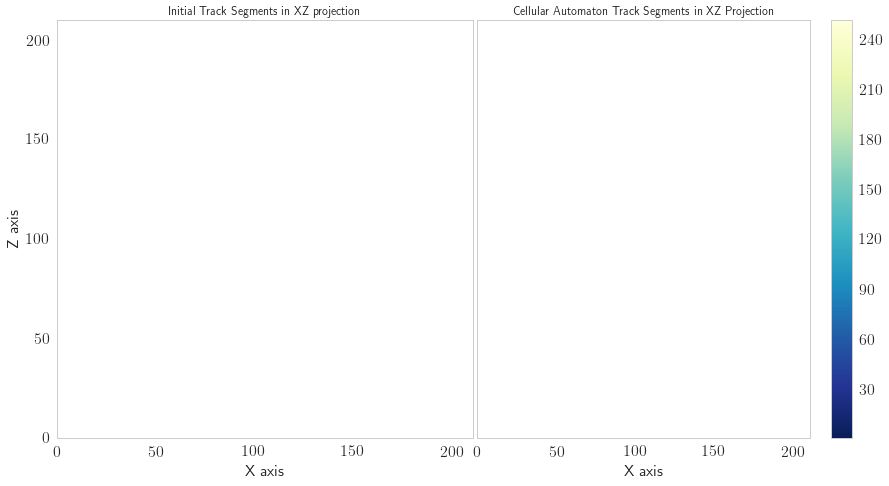

In [43]:
# Filter track segments that still have 0 state
trackSegCA_0 = trackSeg[np.where(stateCurrent==0)]
trackSegCA_NOT_0 = trackSeg[np.where(stateCurrent>0)]

##### Plot initial track segments for XZ projection
figTrackSegCAXZ, (axTrackHitsXZ,axTrackSegCAXZ) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))

# Use LineCollection to efficiently plot the many track segments
lc_0 = mc.LineCollection(zip(zip(trackSegCA_0[:,0],trackSegCA_0[:,1]),zip(trackSegCA_0[:,2],trackSegCA_0[:,3])), linewidths=0.25,color='k')
axTrackSegCAXZ.add_collection(lc_0)

lc = mc.LineCollection(zip(zip(trackSeg[:,0],trackSeg[:,1]),zip(trackSeg[:,2],trackSeg[:,3])), linewidths=0.25,color='k')
axTrackHitsXZ.add_collection(lc)

# Use a colormap to the increasing "state" of track segments
# LineCollection wants a sequence of RGBA tuples
cmap = brewer2mpl.get_map('YlGnBu', 'sequential', 9, reverse=True).mpl_colormap

lc_NOT_0 = mc.LineCollection(zip(zip(trackSegCA_NOT_0[:,0],trackSegCA_NOT_0[:,1]),zip(trackSegCA_NOT_0[:,2],trackSegCA_NOT_0[:,3])),
                             cmap=cmap,
                             norm=plt.Normalize(stateCurrent[np.where(stateCurrent>0)].min(), stateCurrent[np.where(stateCurrent>0)].max()))
lc_NOT_0.set_array(stateCurrent[np.where(stateCurrent>0)])
lc_NOT_0.set_linewidth(0.75)
axTrackSegCAXZ.add_collection(lc_NOT_0)

# Load the image data from CV2 into matplotlib
axTrackSegCAXZ.plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=3, color='red') 
axTrackHitsXZ.plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=3, color='red')

# Axis Properties
axTrackHitsXZ.set_xlim(0,211)
axTrackHitsXZ.set_ylim(0,211)
axTrackSegCAXZ.set_xlim(0,211)
axTrackSegCAXZ.set_ylim(0,211)

axTrackHitsXZ.set_xlabel('X axis')
axTrackSegCAXZ.set_xlabel('X axis')
axTrackHitsXZ.set_ylabel('Z axis')

plt.setp(axTrackSegCAXZ.get_yticklabels(), visible=False)

# Colorbar, make sure to specify tick locations to match desired ticklabels
cbar = figTrackSegCAXZ.colorbar(lc_NOT_0)

# Figure Properties
axTrackHitsXZ.set_title('Initial Track Segments in XZ projection')
axTrackSegCAXZ.set_title('Cellular Automaton Track Segments in XZ Projection')
figTrackSegCAXZ.subplots_adjust(wspace=0.01)

# Save the figure 
fileTrackSegCAXZ ='Track_Segments_Forward_CA_XZ.pdf'
plt.savefig(fileTrackSegCAXZ)
print 'Saving plot of initial track segments for the XZ projection to: ' + fileTrackSegCAXZ

# Show the image
plt.show(figTrackSegCAXZ)


Saving plot of initial track segments for the XZ projection to: Track_Segments_Forward_CA_XZ.pdf


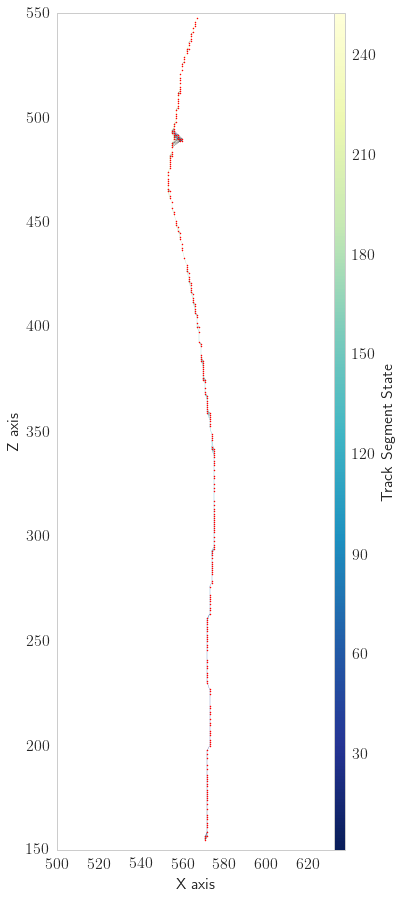

In [45]:
# Filter track segments that still have 0 state
trackSegCA_0 = trackSeg[np.where(stateCurrent==0)]
trackSegCA_NOT_0 = trackSeg[np.where(stateCurrent>0)]

##### Plot track segments for XZ projection after forward Cellular Automaton
figTrackSegCAXZ = plt.figure(figsize=(15, 15))
axTrackSegCAXZ = ImageGrid(figTrackSegCAXZ, 111, # similar to subplot(111)
                nrows_ncols = (1, 1), # creates 2x2 grid of axes
                axes_pad=0., # pad between axes in inch.
                cbar_location="right",
                cbar_mode="single",
                cbar_size="4%",
                cbar_pad=-0.01,
                )

# Use LineCollection to efficiently plot the many track segments
lc_0 = mc.LineCollection(zip(zip(trackSegCA_0[:,0],trackSegCA_0[:,1]),zip(trackSegCA_0[:,2],trackSegCA_0[:,3])), linewidths=0.25,color='k')
axTrackSegCAXZ[0].add_collection(lc_0)

# Use a colormap to the increasing "state" of track segments
# LineCollection wants a sequence of RGBA tuples
cmap = brewer2mpl.get_map('YlGnBu', 'sequential', 9, reverse=True).mpl_colormap

lc_NOT_0 = mc.LineCollection(zip(zip(trackSegCA_NOT_0[:,0],trackSegCA_NOT_0[:,1]),zip(trackSegCA_NOT_0[:,2],trackSegCA_NOT_0[:,3])),
                             cmap=cmap,
                             norm=plt.Normalize(stateCurrent[np.where(stateCurrent>0)].min(), stateCurrent[np.where(stateCurrent>0)].max()))
lc_NOT_0.set_array(stateCurrent[np.where(stateCurrent>0)])
lc_NOT_0.set_linewidth(0.25)
axTrackSegCAXZ[0].add_collection(lc_NOT_0)

lc_NOT_0_2 = mc.LineCollection(zip(zip(trackSegCA_NOT_0[:,0],trackSegCA_NOT_0[:,1]),zip(trackSegCA_NOT_0[:,2],trackSegCA_NOT_0[:,3])),
                             cmap=cmap,
                             norm=plt.Normalize(stateCurrent[np.where(stateCurrent>0)].min(), stateCurrent[np.where(stateCurrent>0)].max()))
lc_NOT_0_2.set_array(stateCurrent[np.where(stateCurrent>0)])
lc_NOT_0_2.set_linewidth(0.25)

# Load the image data from CV2 into matplotlib
axTrackSegCAXZ[0].plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=3, color='red') 

# With cbar_mode="single", cax attribute of all axes are identical.
cbar = plt.colorbar(lc_NOT_0, cax = axTrackSegCAXZ.cbar_axes[0])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Track Segment State')

for cax in axRawXZ.cbar_axes:
    cax.toggle_label(True)

# Axis Properties
axTrackSegCAXZ[0].set_xlim(500,rowsXZ)
axTrackSegCAXZ[0].set_ylim(150,550)
# axTrackSegCAXZ[0].set_xlim(100,200)
# axTrackSegCAXZ[0].set_ylim(100,150)

axTrackSegCAXZ[0].set_xlabel('X axis')
axTrackSegCAXZ[0].set_ylabel('Z axis')

# xTicks = np.array([50,100,150,200])
# yTicks = np.array([50,100,150,200])

# axTrackSegCAXZ[0].set_xticks(xTicks) 
# axTrackSegCAXZ[0].set_yticks(yTicks) 

# Figure Properties
# axTrackSegCAXZ.set_title('Cellular Automaton Track Segments in XZ Projection')

# Inset magnified plot
# axIns = zoomed_inset_axes(axTrackSegCAXZ[0],1.75,loc=4) # zoom=6
# axIns.plot(imgXZHits[:,0], imgXZHits[:,1], '.', ms=10, color='red') 
# axIns.add_collection(lc_NOT_0_2)

# sub region of the original image
# x1, x2, y1, y2 = 20, 50, 50, 80
# x1, x2, y1, y2 = 5, 35, 100, 150
# axIns.set_xlim(x1, x2)
# axIns.set_ylim(y1, y2)
# plt.xticks(visible=False)
# plt.yticks(visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
# mark_inset(axTrackSegCAXZ[0], axIns, loc1=1, loc2=3, fc="0.95", ec="0.05")

# Save the figure 
fileTrackSegCAXZ ='Track_Segments_Forward_CA_XZ.pdf'
plt.savefig(fileTrackSegCAXZ)
print 'Saving plot of initial track segments for the XZ projection to: ' + fileTrackSegCAXZ

# Show the image
plt.show(figTrackSegCAXZ)